**CLASS**: Naive Bayes SMS spam classifier using sklearn

Data source: https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

In [170]:
## READING IN THE DATA

# read tab-separated file using pandas
import pandas as pd
%matplotlib inline


In [171]:
df = pd.read_table('../data/sms.tsv',
                   sep='\t', header=None, names=['label', 'msg'])

In [172]:
# examine the data
df.head()

,label,msg
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


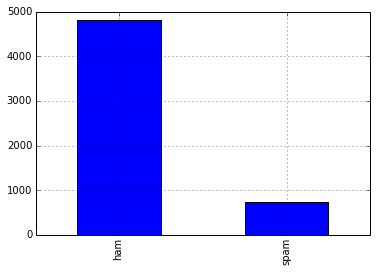

In [173]:
df.label.value_counts().plot(kind='bar')

In [174]:
df.msg.describe()

count                       5572
unique                      5169
top       Sorry, I'll call later
freq                          30
dtype: object

In [175]:
# convert label to a quantitative binary variable
df['label'] = df.label.map({'ham':0, 'spam':1})
df.head()

,label,msg
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [176]:
# split into training and testing sets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.msg, df.label, random_state=1)

In [177]:
from sklearn.feature_extraction.text import CountVectorizer
# start with a simple example
train_simple = ['call you tonight',
                'Call me a cab',
                'please call me... PLEASE 44!']

# learn the 'vocabulary' of the training data
vect = CountVectorizer()
train_simple_dtm = vect.fit_transform(train_simple)
vect.get_feature_names()

[u'44', u'cab', u'call', u'me', u'please', u'tonight', u'you']

In [178]:
# transform training data into a 'document-term matrix'
train_simple_dtm = vect.transform(train_simple)
train_simple_dtm

<3x7 sparse matrix of type '<type 'numpy.int64'>'
	with 10 stored elements in Compressed Sparse Row format>

In [179]:
# examine the vocabulary and document-term matrix together
pd.DataFrame(train_simple_dtm.toarray(), columns=vect.get_feature_names())

,44,cab,call,me,please,tonight,you
0,0,0,1,0,0,1,1
1,0,1,1,1,0,0,0
2,1,0,1,1,2,0,0


In [180]:
# transform testing data into a document-term matrix (using existing vocabulary, notice don't is missing)
test_simple = ["please don't call me"]
test_simple_dtm = vect.transform(test_simple)
test_simple_dtm.toarray()
pd.DataFrame(test_simple_dtm.toarray(), columns=vect.get_feature_names())

,44,cab,call,me,please,tonight,you
0,0,0,1,1,1,0,0


In [181]:
## REPEAT PATTERN WITH SMS DATA

# instantiate the vectorizer
vect = CountVectorizer()

# learn vocabulary and create document-term matrix in a single step
train_dtm = vect.fit_transform(X_train)
train_dtm

<4179x7456 sparse matrix of type '<type 'numpy.int64'>'
	with 55209 stored elements in Compressed Sparse Row format>

In [182]:
# transform testing data into a document-term matrix
test_dtm = vect.transform(X_test)
test_dtm

<1393x7456 sparse matrix of type '<type 'numpy.int64'>'
	with 17604 stored elements in Compressed Sparse Row format>

In [183]:
# store feature names and examine them
train_features = vect.get_feature_names()
len(train_features)
train_features[:10], train_features[-10:]

([u'00',
  u'000',
  u'008704050406',
  u'0121',
  u'01223585236',
  u'01223585334',
  u'0125698789',
  u'02',
  u'0207',
  u'02072069400'],
 [u'zed',
  u'zeros',
  u'zhong',
  u'zindgi',
  u'zoe',
  u'zoom',
  u'zouk',
  u'zyada',
  u'\xe8n',
  u'\u3028ud'])

In [184]:
# convert train_dtm to a regular array
train_arr = train_dtm.toarray()
# remember that each ROW is an sms
# and each COLUMN is a token
train_arr

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [185]:
## SIMPLE SUMMARIES OF THE TRAINING DATA
# refresher on numpy
import numpy as np
arr = np.array([[1, 2, 3, 4], [5, 6, 7, 8]])
arr

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [186]:
sum(arr[0, :]) #sum of the first row

10

In [187]:
sum(arr[:,0]) # sum of the first column

6

In [239]:
################
### EXERCISE ###
################
# count how many times the 0th token appears across ALL messages in train_arr


In [241]:
################
### EXERCISE ###
################
#calculate the number of tokens in the 0th message in train_arr


In [190]:
np.sum(arr) # adds up all numbers

36

In [191]:
np.sum(arr, axis=0) # adds up by column

array([ 6,  8, 10, 12])

In [192]:
np.sum(arr, axis=1)  # adds up by row

array([10, 26])

In [243]:
################
### EXERCISE ###
################
# count how many times EACH token appears across ALL messages in train_arr


array([ 5, 23,  2, ...,  1,  1,  1])

In [194]:
# create a dataframe with two columns, "count" and "token" that holds the token count for each token
# use the numpy sum methods
train_token_counts = pd.DataFrame({'token':train_features, 'count':np.sum(train_arr, axis=0)})
train_token_counts.sort_index(by='count', ascending=False).head()

,count,token
6656,1670,to
7420,1660,you
6542,1004,the
929,717,and
3502,683,in


In [195]:
## MODEL BUILDING WITH NAIVE BAYES
## http://scikit-learn.org/stable/modules/naive_bayes.html

# train a Naive Bayes model using train_dtm
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(train_dtm, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [196]:
# make predictions on test data using test_dtm
preds = nb.predict(test_dtm)
preds

array([0, 0, 0, ..., 0, 1, 0])

In [197]:
# compare predictions to true labels
from sklearn import metrics
print metrics.accuracy_score(y_test, preds)
print metrics.confusion_matrix(y_test, preds)

0.988513998564
[[1203    5]
 [  11  174]]


In [198]:
# predict (poorly calibrated) probabilities and calculate AUC
probs = nb.predict_proba(test_dtm)[:, 1]
probs
print metrics.roc_auc_score(y_test, probs)

0.986643100054


In [235]:
################
### EXERCISE ###
################
# show the message text for the false positives


In [237]:
################
### EXERCISE ###
################
# show the message text for the false negatives


In [201]:
## COMPARE NAIVE BAYES AND LOGISTIC REGRESSION
## USING ALL DATA AND CROSS-VALIDATION
vect = CountVectorizer(ngram_range=(1,3), stop_words='english')
# create a document-term matrix using all data
all_dtm = vect.fit_transform(df.msg)

# instantiate logistic regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

# compare AUC using cross-validation
# note: this is slightly improper cross-validation... can you figure out why?
from sklearn.cross_validation import cross_val_score

from datetime import datetime

In [202]:
now = datetime.now()
mean = cross_val_score(logreg, all_dtm, df.label, cv=10, scoring='accuracy').mean()
print (datetime.now()-now).total_seconds(), "Seconds for logistic regression", mean

0.880958 Seconds for logistic regression 0.976848539122


In [203]:
now = datetime.now()
mean = cross_val_score(nb, all_dtm, df.label, cv=10, scoring='accuracy').mean()
print (datetime.now()-now).total_seconds(), "Seconds for naive bayes", mean
# about 4 times faster

0.205042 Seconds for naive bayes 0.967516659054


In [204]:
'''
Model evaluation metrics (confusion matrix, ROC/AUC)
'''

## READ DATA AND SPLIT INTO TRAIN/TEST

# read in the data
import pandas as pd
data = pd.read_csv('../data/Default.csv')
data.head()

,default,student,balance,income
0,0,No,729.526495,44361.62507
1,0,Yes,817.180407,12106.13470
2,0,No,1073.549164,31767.13895
3,0,No,529.250605,35704.49394
4,0,No,785.655883,38463.49588


In [205]:
# create X and y
X = data[['balance']]
y = data.default

In [206]:
# split into train and test
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [207]:
# create logistic regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [208]:
# predict and calculate accuracy in one step
logreg.score(X_test, y_test)

0.9748

In [209]:
# predict in one step, calculate accuracy in a separate step
preds = logreg.predict(X_test)
from sklearn import metrics
print metrics.accuracy_score(y_test, preds)

0.9748


In [210]:
# compare to null accuracy rate
y_test.mean()
1 - y_test.mean()

0.96840000000000004

In [211]:
## CONFUSION MATRIX

# print confusion matrix
print metrics.confusion_matrix(y_test, preds)

[[2416    5]
 [  58   21]]


In [212]:
# nicer confusion matrix
from nltk import ConfusionMatrix
print ConfusionMatrix(list(y_test), list(preds))

  |    0    1 |
--+-----------+
0 |<2416>   5 |
1 |   58  <21>|
--+-----------+
(row = reference; col = test)



In [213]:
# sensitivity: percent of correct predictions when reference value is 'default'
21 / float(58 + 21)
print metrics.recall_score(y_test, preds)

# specificity: percent of correct predictions when reference value is 'not default'
print 2416 / float(2416 + 5)


0.26582278481
0.997934737712


(array([  2.23000000e+03,   1.23000000e+02,   6.30000000e+01,
          2.90000000e+01,   2.30000000e+01,   1.10000000e+01,
          1.00000000e+01,   6.00000000e+00,   1.00000000e+00,
          4.00000000e+00]),
 array([  1.87839293e-04,   8.91943925e-02,   1.78200946e-01,
          2.67207499e-01,   3.56214052e-01,   4.45220605e-01,
          5.34227159e-01,   6.23233712e-01,   7.12240265e-01,
          8.01246818e-01,   8.90253371e-01]),
 <a list of 10 Patch objects>)

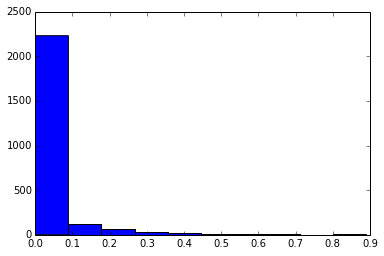

In [214]:
# predict probabilities
import matplotlib.pyplot as plt
probs = logreg.predict_proba(X_test)[:, 1]
plt.hist(probs)

In [215]:
# use 0.5 cutoff for predicting 'default'
import numpy as np
preds = np.where(probs > 0.5, 1, 0)
print ConfusionMatrix(list(y_test), list(preds))

  |    0    1 |
--+-----------+
0 |<2416>   5 |
1 |   58  <21>|
--+-----------+
(row = reference; col = test)



In [216]:
# change cutoff for predicting default to 0.2
preds = np.where(probs > 0.2, 1, 0)
print ConfusionMatrix(list(y_test), list(preds))

  |    0    1 |
--+-----------+
0 |<2340>  81 |
1 |   34  <45>|
--+-----------+
(row = reference; col = test)



In [217]:
# check accuracy, sensitivity, specificity
print metrics.accuracy_score(y_test, preds)
print 45 / float(34 + 45)
print 2340 / float(2340 + 81)

0.954
0.569620253165
0.966542750929


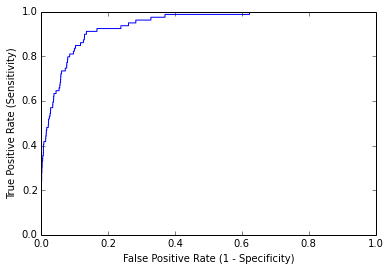

In [218]:
## ROC CURVES and AUC

# plot ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

In [219]:
# calculate AUC
print metrics.roc_auc_score(y_test, probs)

0.941011926236


In [220]:
# use AUC as evaluation metric for cross-validation
from sklearn.cross_validation import cross_val_score
X = data[['balance']]
y = data.default
logreg = LogisticRegression()
cross_val_score(logreg, X, y, cv=10, scoring='roc_auc').mean()

0.9481909984306196

In [221]:
# compare to a model with an additional feature
X = data[['balance', 'income']]
cross_val_score(logreg, X, y, cv=10, scoring='roc_auc').mean()

0.59503752064417681

In [222]:
# ROC/AUC are very meaningful when:
# 1. class sizes are inbalances
# 2. comparing across different binary classification models

In [223]:
## BONUS: CALCULATE THE 'SPAMMINESS' OF EACH TOKEN


# create separate DataFrames for ham and spam
df_ham = df[df.label==0]
df_spam = df[df.label==1]

In [224]:
# learn the vocabulary of ALL messages and save it
vect = CountVectorizer(ngram_range=(1,1), stop_words='english')
vect.fit(df.msg)
all_features = vect.get_feature_names()

In [225]:
# create document-term matrix of ham, then convert to a regular array
ham_dtm = vect.transform(df_ham.msg)
ham_arr = ham_dtm.toarray()
ham_dtm

<4825x8445 sparse matrix of type '<type 'numpy.int64'>'
	with 32267 stored elements in Compressed Sparse Row format>

In [226]:
# create document-term matrix of spam, then convert to a regular array
spam_dtm = vect.transform(df_spam.msg)
spam_arr = spam_dtm.toarray()
spam_dtm

<747x8445 sparse matrix of type '<type 'numpy.int64'>'
	with 11312 stored elements in Compressed Sparse Row format>

In [227]:
# count how many times EACH token appears across ALL messages in ham_arr
ham_counts = np.sum(ham_arr, axis=0)

In [228]:
# count how many times EACH token appears across ALL messages in spam_arr
spam_counts = np.sum(spam_arr, axis=0)

In [229]:
# create a DataFrame of tokens with their separate ham and spam counts
all_token_counts = pd.DataFrame({'token':all_features, 'ham':ham_counts, 'spam':spam_counts})
all_token_counts.head()

,ham,spam,token
0,0,10,00
1,0,29,000
2,1,0,000pes
3,0,2,008704050406
4,0,1,0089


In [230]:
# add one to ham counts and spam counts so that ratio calculations (below) make more sense
all_token_counts['ham'] = all_token_counts.ham + 1
all_token_counts['spam'] = all_token_counts.spam + 1

In [231]:
# calculate ratio of spam-to-ham for each token
all_token_counts['spam_ratio'] = all_token_counts.spam / all_token_counts.ham
all_token_counts.sort_index(by='spam_ratio', ascending = False).head(10)

,ham,spam,token,spam_ratio
2013,1,114,claim,114
5935,1,94,prize,94
352,1,72,150p,72
7612,1,61,tone,61
369,1,52,18,52
3589,1,51,guaranteed,51
2314,1,45,cs,45
617,1,45,500,45
299,1,42,1000,42
1301,1,39,awarded,39
